In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

In [2]:
samples = [
    "DYJetsToLL_M10to50"
]
fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=4) #CHANGED: background appears to use v2 ntuples instead of v4

In [3]:
runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = ["4mu"]
p = sidm_processor.SidmProcessor(
    channels, ["base_plus_gen"] ) # not sure if base_plus_gen applies to the background

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

# Overall, this takes the samples listed in "samples" (section [2]), then processes them in the sidm_processor function.
# Without actual background data, I'm not sure of the format I should use for the samples, or whether the "base_plus_gen" set applies here.
# Regardless, the histograms generated should be stored in the variable "out".

Output()

Output()

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   muons :  looseID
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  ifcsczero
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  segOverlap < 0.66
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False
Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this JaggedSelection.   dsaMuons :  DT + CSC hits > 12
Uh oh, haven't evaluated this cut yet! 

/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/p

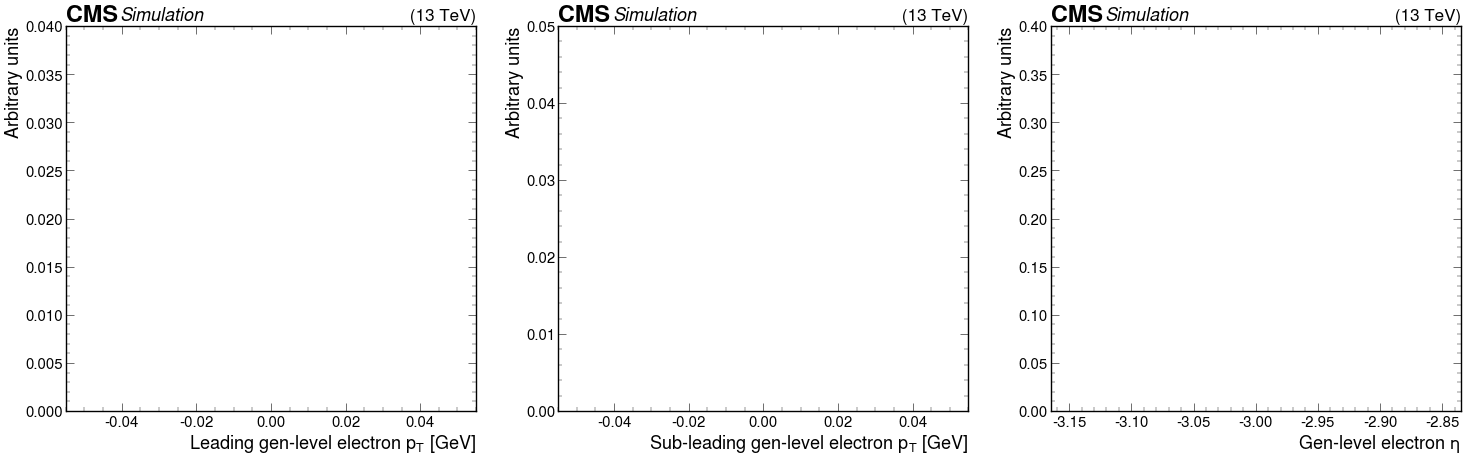

In [4]:
# leading and subleading electrons (taken in large part from the leptonKinematics note)
# The legends are removed, since I'm not sure what quality the samples will vary over.
# In leptonKinematics, they varied with each sample having a different chi-chibar bound state mass
# but in theory, the background processes are already known, so it might not be neccessary to have multiple lines
# as all parameters should follow SM physics. This might make it more useful to have an average in some way combining
# different processes.

# The samples might be Monte Carlo simulations of different lepton-generating processes, so the overall generation might be
# the sum of all the histograms in the end, so the "total" Standard Model generation of collimated lepton pairs
# could be compared to the different predicted SIDM models for lepton pairs (over different m_A, m_XX, c_tau)

nplots = 3
plt.subplots(1, nplots, figsize=(nplots*12, 10))
plt.subplot(1, nplots, 1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genE0_pt_highRange"][channels[0], :600j], density=True)
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylim(0, 0.04)
    plt.ylabel("Arbitrary units")
plt.subplot(1, nplots, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genE1_pt_highRange"][channels[0], :600j], density=True)
    # plt.legend(masses, title="DM bound state mass", alignment="left")
    plt.ylim(0, 0.05)
    plt.ylabel("Arbitrary units")
plt.subplot(1, nplots, 3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genE_eta_phi"][channels[0], ::2j, :].project("genE_eta"), density=True)
    # plt.legend(masses, title="DM bound state mass", alignment="left", loc="upper left")
    plt.ylim(0, 0.4)
    plt.ylabel("Arbitrary units")